# Fonctions essentiel

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# import segmentation_models_pytorch as smp

In [14]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        # image = image.astype('float32')
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = mask[:,:,0]+mask[:,:,1]

        new_mask = np.zeros((mask.shape[0],mask.shape[1],3),dtype='uint8')
        new_mask[:,:,0] = np.where(mask!=0,255,0)
        new_mask[:,:,1] = np.where(mask!=0,255,0)
        new_mask[:,:,2] = np.where(mask!=0,255,0)
        # one-hot-encode the mask
        mask = one_hot_encode(new_mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

import torch.nn.functional as F
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weights=None):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        # Assurez-vous que les inputs sont sous forme de logits (pas de softmax)
        if self.weights is not None:
            loss = F.cross_entropy(inputs, targets, weight=self.weights)
        else:
            loss = F.cross_entropy(inputs, targets)
        return loss

def dice_coefficient(preds, targets, epsilon=1e-6):
    """
    Calcule le Dice Coefficient entre la prédiction et la vérité terrain.

    :param preds: Tensor des prédictions (sortie du modèle)
    :param targets: Tensor des masques de vérité terrain
    :param epsilon: Petite valeur pour éviter la division par zéro
    :return: Valeur du Dice Coefficient
    """
    preds = torch.argmax(preds, dim=1)  # Convertir les logits en classes (0 ou 1)
    targets = torch.argmax(targets, dim=1)  # Pareil pour la vérité terrain

    intersection = (preds * targets).sum(dim=(1, 2))  # Intersection entre prédiction et GT
    union = preds.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))  # Taille totale des segments

    dice = (2. * intersection + epsilon) / (union + epsilon)  # Calcul du Dice
    return dice.mean()  # Moyenne sur le batch

def show_sample(image,mask):
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.title('Image')
  plt.imshow(image)
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.title('Label : Arabidopsis Thaliana')
  plt.imshow(mask[:,:,0],cmap="gray")
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.title('Label : Fond images')
  plt.imshow(mask[:,:,1],cmap="gray")
  plt.axis('off')

def plot_figure(train_losses,val_losses,train_dices,val_dices,epoch):
  import matplotlib.pyplot as plt

  # Affichage des courbes de perte et du Dice Coefficient
  plt.figure(figsize=(12, 5))

  # Courbe de loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(train_losses)+1), train_losses, label="Train",color='blue')
  plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation",color='orange')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss")
  plt.legend()

  # Courbe de Dice Coefficient
  plt.subplot(1, 2, 2)
  plt.plot(range(1, len(train_dices)+1), train_dices, label="Train",color='blue')
  plt.plot(range(1, len(val_dices)+1), val_dices, label="Validation",color='orange')
  plt.xlabel("Epoch")
  plt.ylabel("Dice")
  plt.title("Dice Coefficient")
  plt.legend()

  # Affichage
  plt.show()

# prompt: je veux prendre le max entre les deux cannaux. si le max est dans le canal 0, on met 255, sinon, 0

def max_channel(image):
    """
    Takes an image as input and returns a binary mask.
    If channel 0 has max value, output is 255, else 0.
    """
    max_values = np.max(image, axis=2)
    channel0_max = (image[:,:,0] == max_values)
    output = np.zeros_like(image[:,:,0], dtype=np.uint8)
    output[channel0_max] = 255
    return output

def dice_coefficient(preds, targets, epsilon=1e-6):
    """
    Calcule le Dice Coefficient entre la prédiction et la vérité terrain.

    :param preds: Tensor des prédictions (sortie du modèle)
    :param targets: Tensor des masques de vérité terrain
    :param epsilon: Petite valeur pour éviter la division par zéro
    :return: Valeur du Dice Coefficient
    """
    preds = torch.argmax(preds, dim=1)  # Convertir les logits en classes (0 ou 1)
    targets = torch.argmax(targets, dim=1)  # Pareil pour la vérité terrain

    intersection = (preds * targets).sum(dim=(1, 2))  # Intersection entre prédiction et GT
    union = preds.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))  # Taille totale des segments

    dice = (2. * intersection + epsilon) / (union + epsilon)  # Calcul du Dice
    return dice.mean()  # Moyenne sur le batch

def show_prediction(ix,color_sample,prob_map_sample,gtrth_sample):
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(color_sample[ix,:,:,:])
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1,4,2)
    plt.imshow(prob_map_sample[ix,:,:,0],cmap='gray')
    plt.title('Prob map')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(max_channel(prob_map_sample[ix,:,:,:]),cmap='gray')
    plt.title('Prediction ')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(gtrth_sample[ix,:,:,0],cmap='gray')
    plt.title('Ground truth')
    plt.axis('off')

# Objectif du TP

Comprendre comment un modèle IA est conçu

# Préparation de la base de données

In [2]:
!wget https://uabox.univ-angers.fr/s/8nNR49DQJfJP7ie/download/herbe.zip
!unzip -q "/content/herbe.zip"

--2025-02-05 16:36:37--  https://uabox.univ-angers.fr/s/8nNR49DQJfJP7ie/download/herbe.zip
Resolving uabox.univ-angers.fr (uabox.univ-angers.fr)... 193.49.144.31
Connecting to uabox.univ-angers.fr (uabox.univ-angers.fr)|193.49.144.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘herbe.zip’

herbe.zip               [        <=>         ]   6.49M  3.09MB/s    in 2.1s    

2025-02-05 16:36:40 (3.09 MB/s) - ‘herbe.zip’ saved [6808065]



## Importer les data dans notre repertoire

In [4]:
DATA_DIR = '/content/herbe/Arabidopsis'

x_train_dir = os.path.join(DATA_DIR, 'Train','images')
y_train_dir = os.path.join(DATA_DIR, 'Train','mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val','images')
y_valid_dir = os.path.join(DATA_DIR, 'Val','mask')

x_test_dir = os.path.join(DATA_DIR, 'Test','images')
y_test_dir = os.path.join(DATA_DIR, 'Test','mask')

In [5]:
class_names = ['plant','background']
class_rgb_values = [[255,255,255],[0,0,0]]

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['plant','background']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

## Echantillon

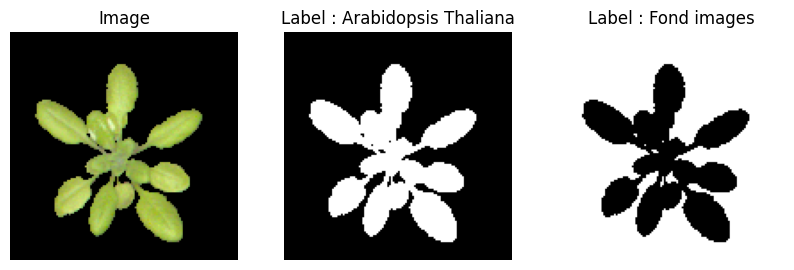

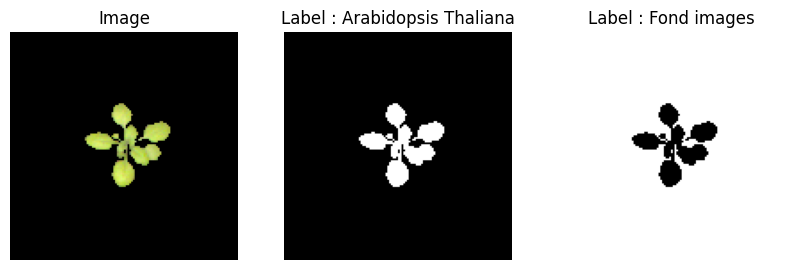

In [6]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_id1,random_id2 = random.randint(0, len(dataset)-1),random.randint(0, len(dataset)-1)
image, mask = dataset[random_id1]
show_sample(image,mask)
image, mask = dataset[random_id2]
show_sample(image,mask)

# Initialisation de l'architecture

In [7]:
class DoubleConv(nn.Module):
    """
    Deux blocks de convolutions successifs :
    Conv2d : Convolution entre une matrice et un noyau
    BatchNorm2d : Normalisation par lots
    ReLU : Fonction d'activation
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    """
    Encoder : sous-échantillonnage de l'image
    Résultat de la double convolution puis application d'un max-pooling sur une matrice pour réduire les dimensions de cette matrice
    """
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    """
    Decoder : sur-échantillonnage de l'image
    nn.ConvTranspose2d : Concatenation de la couche précédente avec la sortie du max-pooling du même niveau
    DoubleConv : Application de deux blocks de convolutions
    """
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    """
    UNet pour une segmentation binaire : classe 0 fond / classe 1 objet
    Hyperparamètres :
    - Nombre de filtre
    """
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Encoder : Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Decoder : Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        # x = nn.functional.softmax(x, dim=-1)
        return x

# Train / Validation / Test

In [34]:
batch_user = 12
learning_rate = 0.001
patience_max = 2
num_epochs = 10
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Entrainement

## Hyperparamètres

Using device: cuda


Epoch 1/10 - Validation: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0129
Epoch 1/10, Train Loss: 0.0365, Train Dice: 0.8277, Val Loss: 0.0129, Val Dice: 0.8199


Epoch 2/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0039
Epoch 2/10, Train Loss: 0.0079, Train Dice: 0.8490, Val Loss: 0.0039, Val Dice: 0.8264


Epoch 3/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.75it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0027
Epoch 3/10, Train Loss: 0.0030, Train Dice: 0.8477, Val Loss: 0.0027, Val Dice: 0.8103


Epoch 4/10 - Validation: 100%|██████████| 14/14 [00:01<00:00, 10.16it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0011
Epoch 4/10, Train Loss: 0.0015, Train Dice: 0.8514, Val Loss: 0.0011, Val Dice: 0.8212


Epoch 5/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.36it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0007
Epoch 5/10, Train Loss: 0.0009, Train Dice: 0.8609, Val Loss: 0.0007, Val Dice: 0.8681


Epoch 6/10 - Validation: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0005
Epoch 6/10, Train Loss: 0.0006, Train Dice: 0.8583, Val Loss: 0.0005, Val Dice: 0.8487


Epoch 7/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0004
Epoch 7/10, Train Loss: 0.0005, Train Dice: 0.8509, Val Loss: 0.0004, Val Dice: 0.8620


Epoch 8/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0003
Epoch 8/10, Train Loss: 0.0004, Train Dice: 0.8504, Val Loss: 0.0003, Val Dice: 0.8645


Epoch 9/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0002
Epoch 9/10, Train Loss: 0.0003, Train Dice: 0.8525, Val Loss: 0.0002, Val Dice: 0.8433


Epoch 10/10 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


✅ Nouveau meilleur modèle sauvegardé avec une loss de 0.0002
Epoch 10/10, Train Loss: 0.0002, Train Dice: 0.8475, Val Loss: 0.0002, Val Dice: 0.8422


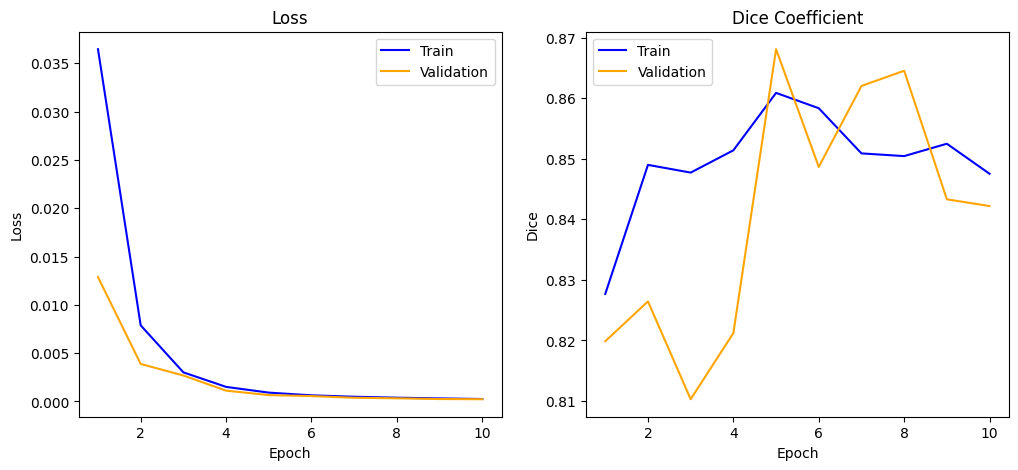

In [35]:
import torch
import torch.nn as nn
import tqdm

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_user, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=batch_user, shuffle=False, num_workers=4)

# Get UNet model
model = UNet()

# Détecter le GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Exemple de poids (ajustez selon le dataset)
class_weights = [0.8, 0.2]
class_weights = torch.tensor(class_weights).to(device)
criterion = WeightedCrossEntropyLoss(weights=class_weights)

# Déplacer le modèle sur GPU
model.to(device)

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')  # Initialisation avec une valeur très grande

train_losses = []
val_losses = []
train_dices = []
val_dices = []

# Entraînement
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    for images, masks in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)  # Déplacer sur GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # train_dice += dice_coefficient(outputs, masks).item()  # Ajout du Dice Score
        softmax_output = nn.functional.softmax(outputs, dim=-1)
        train_dice += dice_coefficient(softmax_output, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)  # Moyenne sur le batch
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0  # Pour stocker la moyenne des scores Dice

    with torch.no_grad():
        for images, masks in tqdm.tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)  # Déplacer sur GPU
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            # val_dice += dice_coefficient(outputs, masks).item()  # Calcul Dice
            softmax_output = nn.functional.softmax(outputs, dim=-1)
            val_dice += dice_coefficient(softmax_output, masks).item()

    # Moyenne sur toutes les batchs
    avg_val_loss = val_loss / len(valid_loader)
    avg_dice = val_dice / len(valid_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss  # Mettre à jour la meilleure loss
        torch.save(model.state_dict(), "best_model.pth")  # Sauvegarde du modèle
        print(f"✅ Nouveau meilleur modèle sauvegardé avec une loss de {best_val_loss:.4f}")
        patience = 0

    if patience >= patience_max or avg_val_loss < 0.000001:
        print("Early stopping")
        break
    else:
        patience += 1

    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)
    val_losses.append(avg_val_loss)
    val_dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_dice:.4f}")

plot_figure(train_losses,val_losses,train_dices,val_dices,epoch)

## Evaluation

In [36]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/best_model.pth'):
    best_model = torch.load('/content/best_model.pth')
    model.load_state_dict(best_model)
    model.to(device)
    print('Loaded UNet model from this run.')

test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_loader = DataLoader(test_dataset, batch_size=batch_user, shuffle=False, num_workers=4)
test_loss = 0
test_dice = 0
if True:
    with torch.no_grad():
        for images, masks in tqdm.tqdm(test_loader, desc="Test"):
            images, masks = images.to(device), masks.to(device)  # Déplacer sur GPU
            outputs = model(images)
            loss = criterion(outputs, masks)

            test_loss += loss.item()
            # test_dice += dice_coefficient(outputs, masks).item()  # Calcul Dice
            softmax_output = nn.functional.softmax(outputs, dim=-1)
            test_dice += dice_coefficient(softmax_output, masks).item()

    # Moyenne sur toutes les batchs
    avg_test_loss = test_loss / len(test_loader)
    avg_test_dice = test_dice / len(test_loader)
print(end='\n')
print('--Evaluation--',end='\n')
print('Loss:', avg_test_loss)
print('Dice:', avg_test_dice)

Loaded UNet model from this run.


Test: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


--Evaluation--
Loss: 0.03975526290014386
Dice: 0.8552693426609039


## Visualisation

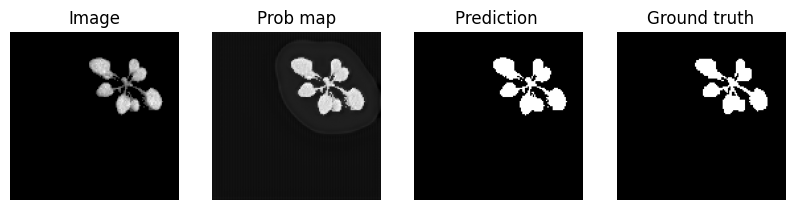

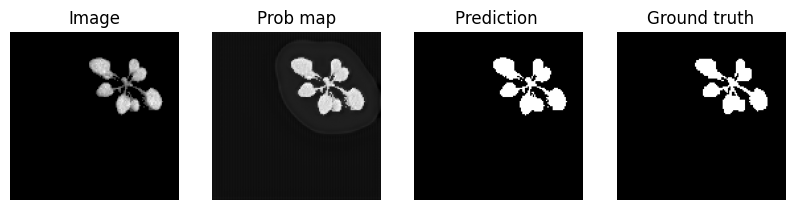

In [37]:
prob_map_sample = outputs.cpu().detach().permute(0,2,3,1).numpy()
color_sample = images.cpu().detach().permute(0,2,3,1).numpy()
gtrth_sample = masks.cpu().detach().permute(0,2,3,1).numpy()

color_sample = color_sample/color_sample.max()
gtrth_sample = gtrth_sample.astype('bool')

n,_,_,_ = prob_map_sample.shape

random_id1,random_id2 = random.randint(0,n-1),random.randint(0,n-1)
show_prediction(random_id1,color_sample,prob_map_sample,gtrth_sample)
show_prediction(random_id2,color_sample,prob_map_sample,gtrth_sample)